In [1]:
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from patchify import patchify, unpatchify
#import cvnn
#import cvnn.layers as complex_layers <- update tf

In [2]:
os.getcwd()

'/data/private/Thesis/May'

In [2]:
# Set parameters
patch_size = 256
n_classes = 2

In [3]:
#model = tf.keras.models.load_model("Output/S1/model_s1.h5")
model = tf.keras.models.load_model("Model/s2_m_5e-6/model.50--0.24.h5")

2023-05-19 22:52:28.563605: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [4]:
# Load image
with rasterio.open("Data/01_Preprocessed/s2_cloud.tif") as src:
    s2 = src.read()
#with rasterio.open("s2_c.tif") as src:
#    s2 = src.read()
with rasterio.open("Data/01_Preprocessed/label_bin.tif") as src:
    label = src.read()

In [5]:
s2 = np.transpose(s2, (1,2,0))
print(s2.shape)

(11806, 18165, 4)


In [7]:
#s2_img = np.transpose(s2, (1,2,0))
#print(s2_img.shape)

In [6]:
label = np.transpose(label, (1,2,0))
print(label.shape)

(11806, 18165, 1)


**Apply by function from practical**

In [7]:
def pad_image_to_patch_size(image, patch_size=patch_size):
    height, width, depth = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = np.zeros((target_height, target_width, depth))
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)

In [8]:
def apply_segmentation_with_fcn(image, fcn, patch_size=patch_size, step=patch_size//2):
    original_height, original_width, _ = image.shape
    padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    height, width, _ = padded.shape
    
    predictions = np.zeros((height, width, n_classes))
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = padded[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = fcn.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            predictions[row:row + patch_size, col:col + patch_size, :] += \
                row_predictions[patch_idx]
            col += step
            patch_idx += 1

        row += step

    predictions = predictions[
        pad_height:pad_height + original_height,
        pad_width:pad_width + original_width, :
    ]
    predictions = np.argmax(predictions, axis=-1)
    
    return predictions

In [9]:
# Classify image
prediction = apply_segmentation_with_fcn(s2, model)

## **Visualization and Export**

In [10]:
s2 = np.transpose(s2, (2,0,1))
print(s2.shape)

(4, 11806, 18165)


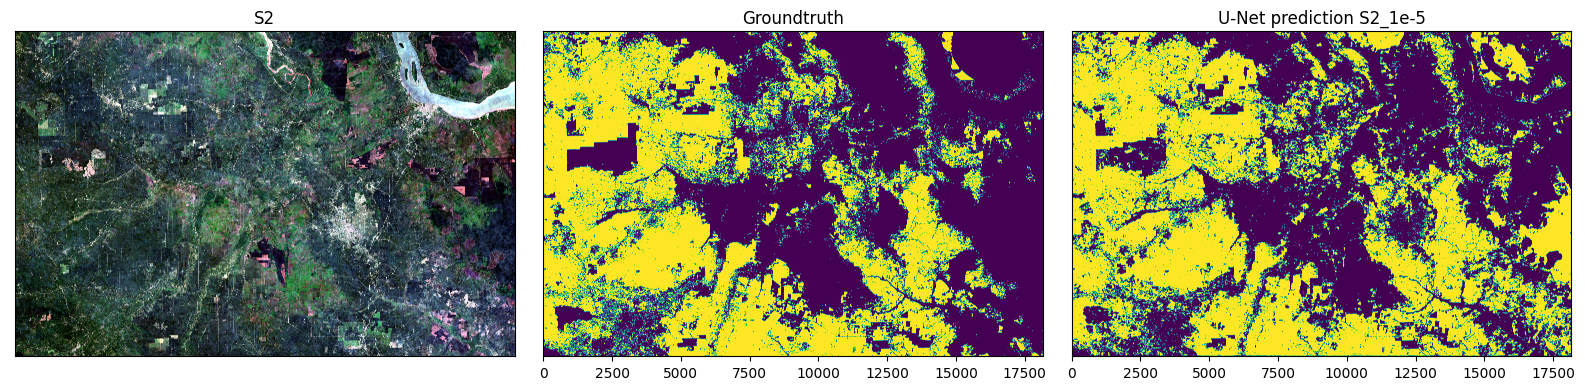

In [14]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7), sharey=True)

axs[0] = ep.plot_rgb(s2, rgb=(2, 1, 0), ax=axs[0], stretch=True, title="S2",)
#axs[0].imshow(s2_img[:, :, [2, 1, 0]])
#axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction S2_1e-5")

plt.tight_layout()
plt.show()

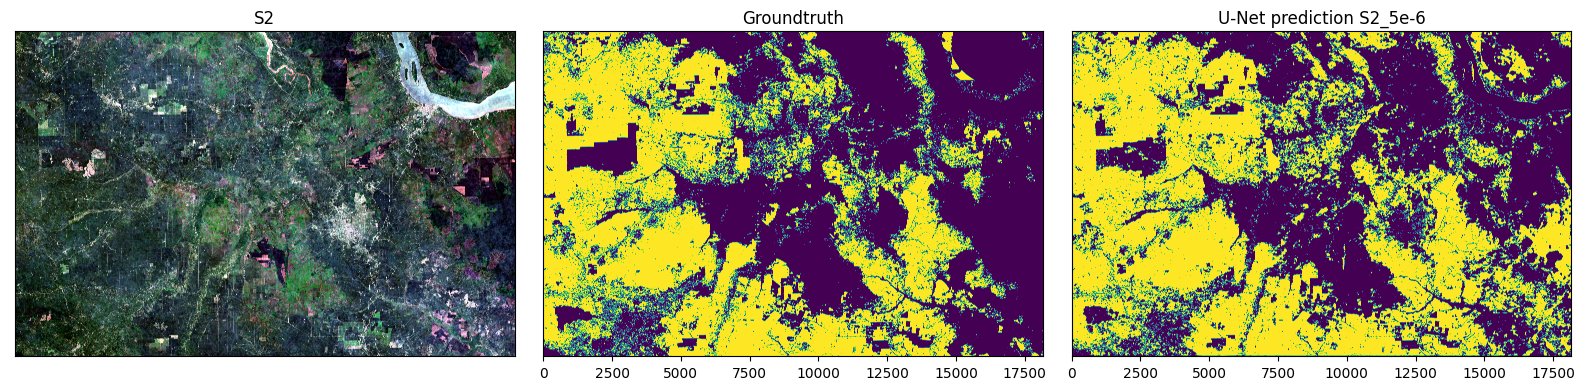

In [13]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7), sharey=True)

axs[0] = ep.plot_rgb(s2, rgb=(2, 1, 0), ax=axs[0], stretch=True, title="S2",)
#axs[0].imshow(s2_img[:, :, [2, 1, 0]])
#axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction S2_5e-6")

plt.tight_layout()
plt.show()

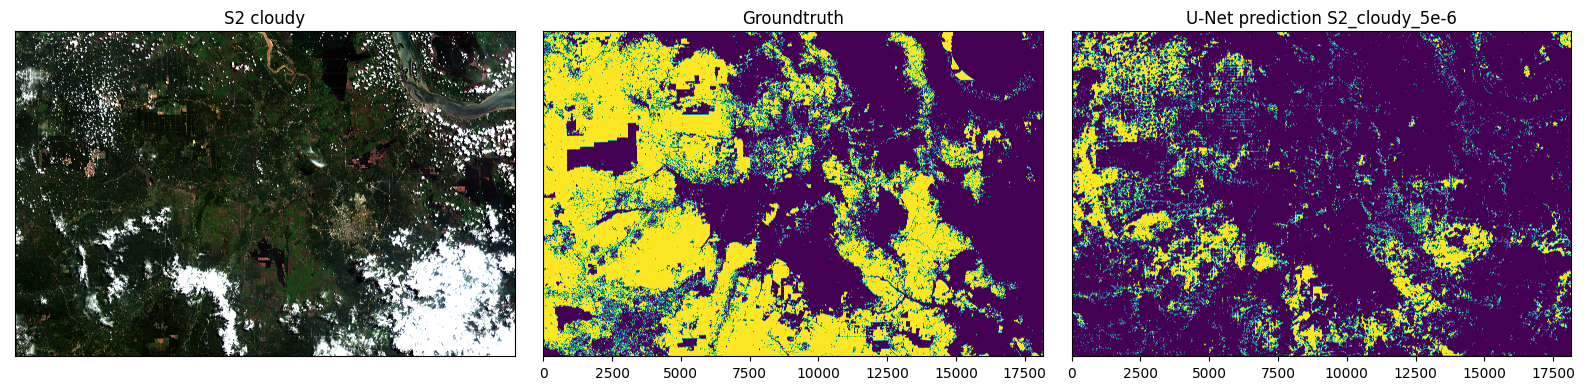

In [11]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7), sharey=True)

axs[0] = ep.plot_rgb(s2, rgb=(2, 1, 0), ax=axs[0], stretch=True, title="S2 cloudy",)
#axs[0].imshow(s2_img[:, :, [2, 1, 0]])
#axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction S2_cloudy_5e-6")

plt.tight_layout()
plt.show()

In [19]:
#ras_meta

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -3.4e+38, 'width': 11570, 'height': 11460, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 619500.0,
       0.0, -10.0, 209600.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [12]:
# Export
with rasterio.open("Data/01_Preprocessed/label_bin.tif") as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['dtype'] = "int8"
ras_meta['nodata'] = -99

with rasterio.open('Output/pred_s2_cloudy_5e-6.tif', 'w', **ras_meta) as dst:
    dst.write(prediction, 1)